In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import utils 
import torch
from torch import nn


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:

subjID = 'K-Reg-S-18'
task = 'one_dot'
df = utils.load_mouseMovement(subjID, task)
df.head()

screenSise = utils.getScreenSise(df)
df_ = df[['trialno', 'x-shift', 'y-shift']].copy()
df_['x-shift'] /= screenSise
df_['y-shift'] /= screenSise
df_.head()

In [4]:
subjID = 'K-Reg-S-18'
task = 'one_dot'
df = utils.load_mouseMovement(subjID, task)
df.head()

,trialno,frameCounter,x-shift,y-shift,dot-x,dot-y,group,subjID
0,1.0,1.0,-15.2,24.4,934.096038,527.534657,S,K-Reg-S-18
1,1.0,2.0,-0.8,0.8,933.121802,526.959450,S,K-Reg-S-18
2,1.0,3.0,-0.4,0.0,933.039034,526.568106,S,K-Reg-S-18
3,1.0,4.0,-0.4,0.0,932.952638,526.177548,S,K-Reg-S-18
4,1.0,5.0,-0.4,0.0,932.857495,525.789028,S,K-Reg-S-18


In [5]:
screenSise = utils.getScreenSise(df)
df_ = df[['trialno', 'x-shift', 'y-shift']].copy()
df_['x-shift'] /= screenSise
df_['y-shift'] /= screenSise
df_.head()

,trialno,x-shift,y-shift
0,1.0,-0.008000,0.012842
1,1.0,-0.000421,0.000421
2,1.0,-0.000211,0.000000
3,1.0,-0.000211,0.000000
4,1.0,-0.000211,0.000000


In [6]:
nValidTrials = 6

trials = set(df_['trialno'])
trials_val = np.random.choice(list(trials), nValidTrials)
trial_train = trials.difference(trials_val)

In [93]:
wSize = int(1.2 * 60)
interval = 1

d_train = []
d_val = []
for iTrial in set(df_['trialno']):
    d_ = df_.query(f'trialno == {iTrial}')
    d_ = d_.drop(columns='trialno').values
    d_ = utils.rollingWindow(d_, wSize, interval)
    if iTrial in trial_train:
        d_train.append(d_)
    else:
        d_val.append(d_)

d_train = np.concatenate(d_train, axis=0)
d_val = np.concatenate(d_val, axis=0)


In [94]:
class TrajDataset(torch.utils.data.Dataset):
    def __init__(self, d):
        self.d = d

    def __len__(self):
        return self.d.shape[0]
    
    def __getitem__(self, idx):
        return self.d[idx]

dataset_train = TrajDataset(d_train)
dataset_val = TrajDataset(d_val)


In [140]:
class TrajNet(nn.Module):
    def __init__(self, nFeature=8, nhead=8, dim_feedforward=256, num_layers=4, wSize=72, dropout=0.1):
        super(TrajNet, self).__init__()

        self.nFeature = nFeature

        # encoder
        self.conv_enc = nn.Conv1d(2, nFeature, 1)
        encoder_ = nn.TransformerEncoderLayer(d_model=nFeature,
                                              nhead=nhead,
                                              dim_feedforward=dim_feedforward,
                                              batch_first=True, 
                                              activation='gelu',
                                              dropout=dropout)
        self.encoder = nn.TransformerEncoder(encoder_, num_layers=num_layers)

        # hidden bottleneck
        self.hidden = nn.Linear(nFeature*wSize, nFeature)
        

        # decoder
        self.hidden_out = nn.Linear(nFeature, nFeature*wSize)
        self.conv_dec1 = nn.Conv1d(nFeature, nFeature, 1)        
        decoder_ = nn.TransformerEncoderLayer(d_model=nFeature, 
                                              nhead=nhead, 
                                              dim_feedforward=dim_feedforward, 
                                              batch_first=True, 
                                              activation='gelu',
                                              dropout=dropout)
        self.decoder = nn.TransformerEncoder(decoder_, num_layers=num_layers)
        generator_ = nn.TransformerEncoderLayer(d_model=nFeature, 
                                                nhead=nhead, 
                                                dim_feedforward=dim_feedforward, 
                                                batch_first=True, 
                                                activation='gelu',
                                                dropout=dropout)        
        self.generator = nn.TransformerEncoder(generator_, num_layers=num_layers)
        self.conv_dec2 = nn.Conv1d(nFeature, 2, 1)
        
        # output
        # self.output = nn.Linear(nFeature, 2)        

    def forward(self, src):
        # src.shape = (batch_size, nSrc, nFeature=2)
        # tgt.shape = (batch_size, nTgt, nFeature=2)
        
        # ---------------------------------------------------------------------------- #
        #                                   encoding                                   #
        # ---------------------------------------------------------------------------- #
        nBatch = src.shape[0]
        nTime = src.shape[1]
        x = src
        
        # expend feature dimension
        #   x_expand = (batch, time, nFeature)
        x = x.permute(0, 2, 1)
        x = self.conv_enc(x)
        x = x.permute(0, 2, 1)

        x = self.encoder(x)
        x = torch.flatten(x, 1)
        x = nn.functional.gelu(x)

        # extract hidden control units
        #   x.shape = (batch, head)
        y = self.hidden(x)
        y = nn.functional.gelu(y)
        y = self.hidden_out(y)
        y = y.reshape(nBatch, nTime, self.nFeature)
        y = nn.functional.gelu(y)

        # construct output embedding
        # y = nn.functional.gelu(y)
        
        # ---------------------------------------------------------------------------- #
        #                                   decoding                                   #
        # ---------------------------------------------------------------------------- #

           
        # decode control command
        y = self.decoder(y)

        # generate motor sequence
        #   y.shape = (batch_size, nTime, nFeature=2)
        src_mask = nn.Transformer.generate_square_subsequent_mask(y.shape[1]).to(device)
        # y = self.generator(y, mask=src_mask)
        y = self.generator(y)
        y = y.permute(0, 2, 1)
        y = self.conv_dec2(y)
        y = y.permute(0, 2, 1)
        return y
    
    # def autoRegressiveDecoding(self, src, nTime):
    #     tgt = torch.zeros((src.shape[0], 1, 2)).to(device).float()
    #     for i in range(nTime):
    #         y = self.forward(src, tgt)[:, -1:, :]
    #         tgt = torch.concat((tgt, y), dim=1)
    #     return tgt[:, 1:, :]
    
# model = TrajNet().to(device)
# model(torch.rand(2, 3, 2).to(device).float())


In [141]:
model = TrajNet().to(device)
model(torch.rand(2, 72, 2).to(device).float())

tensor([[[-0.4890, -0.1939],
         [-0.9642,  0.3834],
         [-0.3664, -0.3175],
         [-0.6417,  0.2267],
         [-0.7152,  0.1602],
         [-0.8695, -0.4278],
         [-0.1559, -0.9841],
         [-0.1882,  0.0738],
         [-0.5431, -0.2539],
         [-0.5405,  0.6919],
         [-0.1312, -0.3456],
         [-0.1013, -0.2890],
         [-0.4807, -0.6208],
         [-0.5455, -1.2067],
         [-0.4807, -0.7830],
         [-0.8185, -0.7021],
         [-0.4797, -0.9428],
         [-0.9357,  0.2160],
         [-0.7871, -0.4438],
         [-0.4012, -0.4202],
         [-0.2284,  0.2483],
         [-0.4070, -0.5565],
         [-0.5521, -1.0808],
         [-0.1613, -0.2208],
         [-0.4826, -0.6159],
         [-0.1067, -0.8567],
         [-0.4351,  0.3762],
         [-0.8551, -0.0282],
         [-0.3361,  0.2706],
         [-0.2122,  0.1515],
         [-0.5882, -0.8270],
         [-0.3318, -0.2538],
         [-0.6434,  0.1007],
         [-0.2869, -0.4355],
         [-0.5

In [142]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
model = TrajNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

In [143]:
model.train()
for epoch in range(50):
    running_loss = 0.0
    for i, batch in enumerate(train_loader):
        optimizer.zero_grad()
        x = batch.to(device).float()
        y = model(x)
        loss = criterion(y, x)
        loss.backward()
        optimizer.step()        
        running_loss += loss.item()
        # print(f'loss: {loss.item()}')
    print(f'epoch:{epoch}, running_loss: {running_loss/(i+1)}')


epoch:0, running_loss: 0.0052695456389361415
epoch:1, running_loss: 0.0005632472811928634
epoch:2, running_loss: 0.0003857017031736048
epoch:3, running_loss: 0.00030967409809375286
epoch:4, running_loss: 0.0002696896491922098
epoch:5, running_loss: 0.00024564026819180393
epoch:6, running_loss: 0.0002310914224572716
epoch:7, running_loss: 0.0002220843214367937
epoch:8, running_loss: 0.00021672112207450823
epoch:9, running_loss: 0.0002128374943808714
epoch:10, running_loss: 0.00020979643070439188
epoch:11, running_loss: 0.00020753122506566289
epoch:12, running_loss: 0.00020608802734954556
epoch:13, running_loss: 0.00020447005019913223
epoch:14, running_loss: 0.00020325011491000199
epoch:15, running_loss: 0.0002026574826961251
epoch:16, running_loss: 0.00020168766845904081
epoch:17, running_loss: 0.00020109954719114954
epoch:18, running_loss: 0.00020055298434646073
epoch:19, running_loss: 0.0001998226421880465
epoch:20, running_loss: 0.00019956269482597426
epoch:21, running_loss: 0.000199

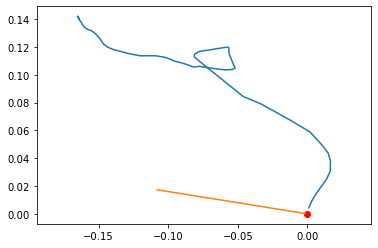

In [144]:
d = dataset_train[10000]
# d = dataset_val[63]

fig, axs = plt.subplots()
axs.plot(d[:, 0].cumsum(), d[:, 1].cumsum(), '-')
axs.plot(0, 0, 'or')
axs.axis('equal')

model.eval()
d_ = torch.from_numpy(d).unsqueeze(0).to(device).float()
d_ = model.forward(d_)
d_ = d_.detach().cpu().numpy()
d_ = d_.squeeze()
axs.plot(d_[:, 0].cumsum(), d_[:, 1].cumsum(), '-')


In [145]:
model(torch.rand(2, 72, 2).to(device).float())

tensor([[[-0.0015,  0.0002],
         [-0.0015,  0.0002],
         [-0.0015,  0.0002],
         [-0.0015,  0.0002],
         [-0.0015,  0.0002],
         [-0.0015,  0.0002],
         [-0.0015,  0.0002],
         [-0.0015,  0.0002],
         [-0.0015,  0.0002],
         [-0.0015,  0.0002],
         [-0.0015,  0.0002],
         [-0.0015,  0.0002],
         [-0.0015,  0.0002],
         [-0.0015,  0.0002],
         [-0.0015,  0.0002],
         [-0.0015,  0.0002],
         [-0.0015,  0.0002],
         [-0.0015,  0.0002],
         [-0.0015,  0.0002],
         [-0.0015,  0.0002],
         [-0.0015,  0.0002],
         [-0.0015,  0.0002],
         [-0.0015,  0.0002],
         [-0.0015,  0.0002],
         [-0.0015,  0.0002],
         [-0.0015,  0.0002],
         [-0.0015,  0.0002],
         [-0.0015,  0.0002],
         [-0.0015,  0.0002],
         [-0.0015,  0.0002],
         [-0.0015,  0.0002],
         [-0.0015,  0.0002],
         [-0.0015,  0.0002],
         [-0.0015,  0.0002],
         [-0.0

In [57]:
d_ = torch.from_numpy(d).unsqueeze(0).to(device).float()
d_ = model.forward(d_)
d_

tensor([[[ 0.0008, -0.0018],
         [ 0.0008, -0.0018],
         [ 0.0008, -0.0018],
         [ 0.0008, -0.0018],
         [ 0.0008, -0.0018],
         [ 0.0008, -0.0018],
         [ 0.0008, -0.0018],
         [ 0.0008, -0.0018],
         [ 0.0008, -0.0018],
         [ 0.0008, -0.0018],
         [ 0.0008, -0.0018],
         [ 0.0008, -0.0018],
         [ 0.0008, -0.0018],
         [ 0.0008, -0.0018],
         [ 0.0008, -0.0018],
         [ 0.0008, -0.0018],
         [ 0.0008, -0.0018],
         [ 0.0008, -0.0018],
         [ 0.0008, -0.0018],
         [ 0.0008, -0.0018],
         [ 0.0008, -0.0018],
         [ 0.0008, -0.0018],
         [ 0.0008, -0.0018],
         [ 0.0008, -0.0018],
         [ 0.0008, -0.0018],
         [ 0.0008, -0.0018],
         [ 0.0008, -0.0018],
         [ 0.0008, -0.0018],
         [ 0.0008, -0.0018],
         [ 0.0008, -0.0018],
         [ 0.0008, -0.0018],
         [ 0.0008, -0.0018],
         [ 0.0008, -0.0018],
         [ 0.0008, -0.0018],
         [ 0.0

In [315]:
d = dataset_train[2000]
src = torch.from_numpy(d).unsqueeze(0).to(device).float()
tgt = torch.zeros((1, 1, 2)).to(device).float()
model.eval()
optimizer.zero_grad()
nTime = int(1.2 * 60)
for i in range(10):
    y = model(src, tgt)[:, -1:, :]
    tgt = torch.concat((tgt, y), dim=1)
tgt = tgt[:, 1:, :]

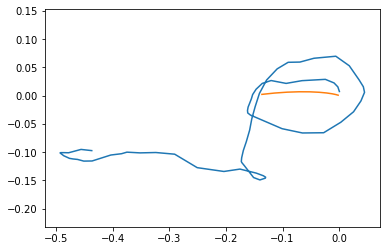

In [316]:
fig, axs = plt.subplots()
axs.plot(d[:, 0].cumsum(), d[:, 1].cumsum(), '-')
axs.axis('equal')

d_ = tgt.detach().cpu().numpy()
d_ = d_.squeeze()
axs.plot(d_[:, 0].cumsum(), d_[:, 1].cumsum(), '-')

In [ ]:
d = dataset_train[2000]
d_ = torch.from_numpy(d).unsqueeze(0).to(device).float()
model.eval()
# genTraj = 
i = 0
d_ = model.forward(d_[:, i, :].unsqueeze(1), add_tgt_mask=False)
d_

In [313]:
a = [1, 2, 3, 4, 5]
a[1]

2

In [ ]:
d

In [ ]:
decoder_layer = nn.TransformerDecoderLayer(d_model=8, nhead=8)
transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers=6)
memory = torch.rand(10, 2, 8)
tgt = torch.rand(4, 2, 8)
transformer_decoder.eval()

In [ ]:
tgt_mask = nn.Transformer.generate_square_subsequent_mask(4)
out = transformer_decoder(tgt, memory, tgt_mask=tgt_mask)
print(out[:, 0, :])

out = transformer_decoder(tgt, memory)
print(out[:, 0, :])

In [ ]:
for i in range(4):
    tgt_mask = nn.Transformer.generate_square_subsequent_mask(i+1)
    if i == 0:
        out = transformer_decoder(tgt[i, :, :].unsqueeze(0), memory, tgt_mask=tgt_mask)
    else:
        out = transformer_decoder(tgt[0:(i+1), :, :], memory, tgt_mask=tgt_mask)
    # out_.append(out)
    print(out[:, 0, :])
    
for i in range(4):
    tgt_mask = nn.Transformer.generate_square_subsequent_mask(i+1)
    if i == 0:
        out = transformer_decoder(tgt[i, :, :].unsqueeze(0), memory, tgt_mask=None)
    else:
        out = transformer_decoder(tgt[0:(i+1), :, :], memory, tgt_mask=None)
    # out_.append(out)
    print(out[:, 0, :])    

In [ ]:
nn.Transformer.generate_square_subsequent_mask(1)

In [ ]:
decoder_layer = nn.TransformerDecoderLayer(d_model=512, nhead=8)
transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers=6)
# memory = torch.rand(10, 32, 512)
# tgt = torch.rand(20, 32, 512)


In [ ]:
out = transformer_decoder(tgt, memory)
out

In [ ]:
encoder_layer = nn.TransformerEncoderLayer(d_model=512, nhead=8, dropout=0.1)
transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=6)
src = torch.rand(10, 32, 512)


In [ ]:
transformer_encoder.eval()
out = transformer_encoder(src)
out